open X:\Macropinocytosis\BMM-KOs\20230823cs5cell1WT\*488nm*.tif;

#surface render#

material dull;

lighting full;

lighting depthcue false;

set bg transparent;

windowsize 800 800;

volume #1 step 3 level 145 color #023b55 voxelsize 0.1028;

view orient;

windowsize 800 800;

ui tool show Shell


In [ ]:
from chimerax.color_key import show_key
from chimerax.core import colors
from chimerax.std_commands.wait import wait
from chimerax.surface import vertex_convexity
from chimerax.core.commands import (BoolArg, Bounded, CmdDesc, ColormapArg,
                                    ColormapRangeArg, Int2Arg, IntArg,
                                    SurfacesArg, StringArg, FloatArg, SurfaceArg, AxisArg)
from chimerax.core.commands.cli import EnumOf
from chimerax.map.volumecommand import volume
from chimerax.std_commands.cd import (cd)
from os.path import exists
import numpy
from chimerax.surface.dust import largest_blobs_triangle_mask 
from numpy import (arccos, array, full, inf, isnan, mean, nan, nanmax, nanmean,
                   nanmin, pi, ravel_multi_index, sign, split, sqrt, subtract,
                   count_nonzero, swapaxes, savetxt, column_stack,nansum, nanstd,
                   unique, column_stack, round_, int64, abs, digitize, linspace,
                   zeros, where, delete, shape, ravel, min, shape, isin,flip)
from scipy.ndimage import (binary_dilation, binary_erosion,
                           generate_binary_structure, iterate_structure, gaussian_filter, gaussian_laplace)
from scipy.spatial import KDTree
from skimage.morphology import (skeletonize,label)
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from chimerax.map_data import ArrayGridData 
from chimerax.map import volume_from_grid_data



In [ ]:
surface=session.models[1]
mask_vol = surface.volume.full_matrix().copy()
level = surface.volume.maximum_surface_level
mask=ArrayGridData((mask_vol>=level))
volume_from_grid_data(mask,session)

In [ ]:

mask=ArrayGridData(gaussian_filter((mask_vol>=level),sigma=0.1))
volume_from_grid_data(mask,session)

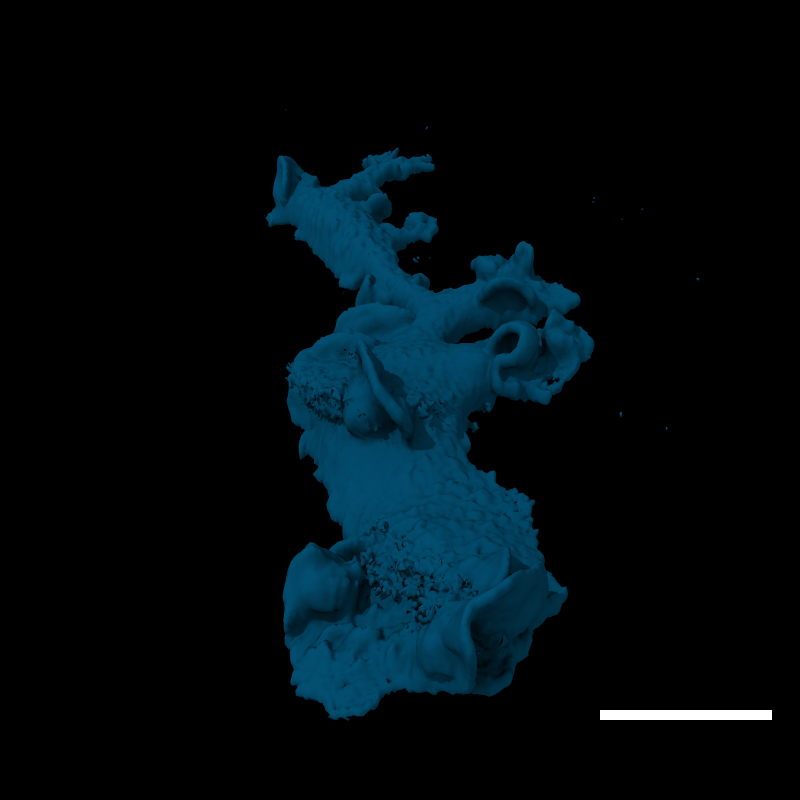
Input

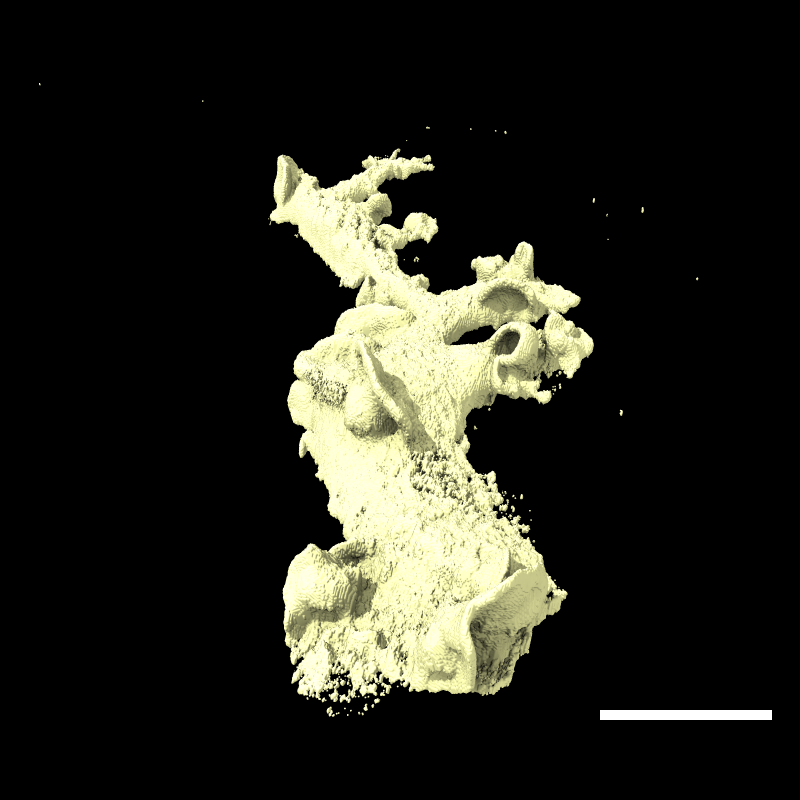
output

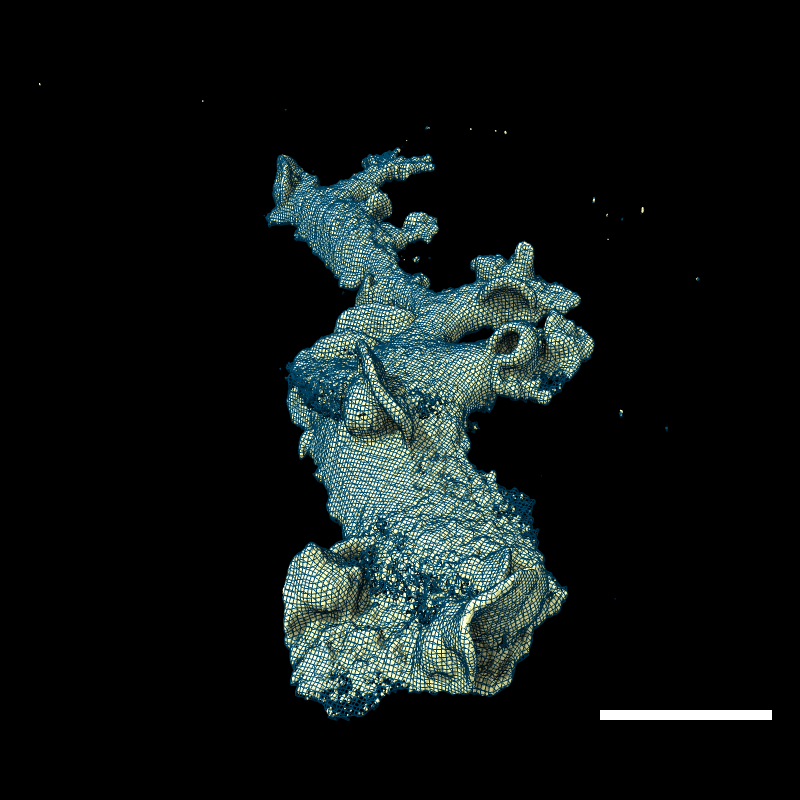
input over the output surface

Generates a new mirror of the masked contour map

In [ ]:

mask=ArrayGridData(((mask_vol<=level)))

volume_from_grid_data(mask,session)

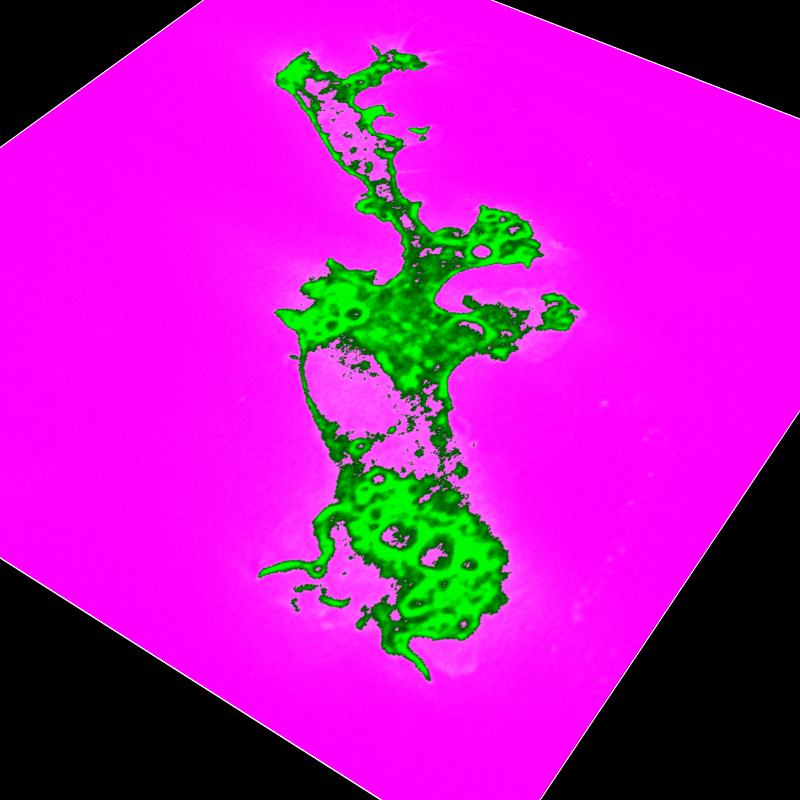
Inverting the surface level to get an inverted mask with voids and external objects identified

Attempting crude implementation of a difference of guassians to edge find the regions of the memebrane in the object

In [ ]:
surface=session.models[1]
mask_vol = surface.volume.full_matrix().copy()
level = surface.volume.maximum_surface_level

gauss_1=gaussian_filter(mask_vol,sigma=0.5)
gauss_2=gaussian_filter(mask_vol,sigma=0.75)
hat=mask_vol*(gauss_2-gauss_1)

mask=ArrayGridData(((hat)))

volume_from_grid_data(mask,session)



Dog
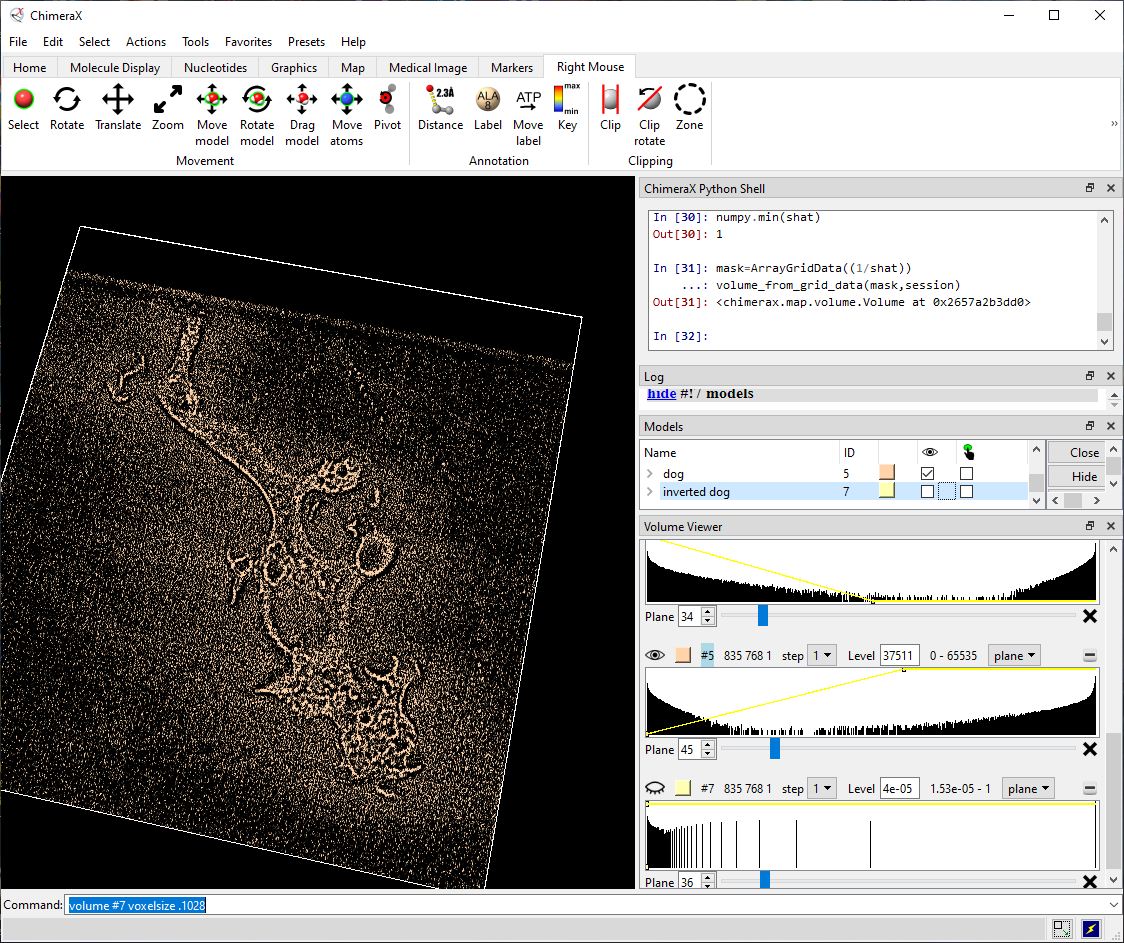

inverted dog
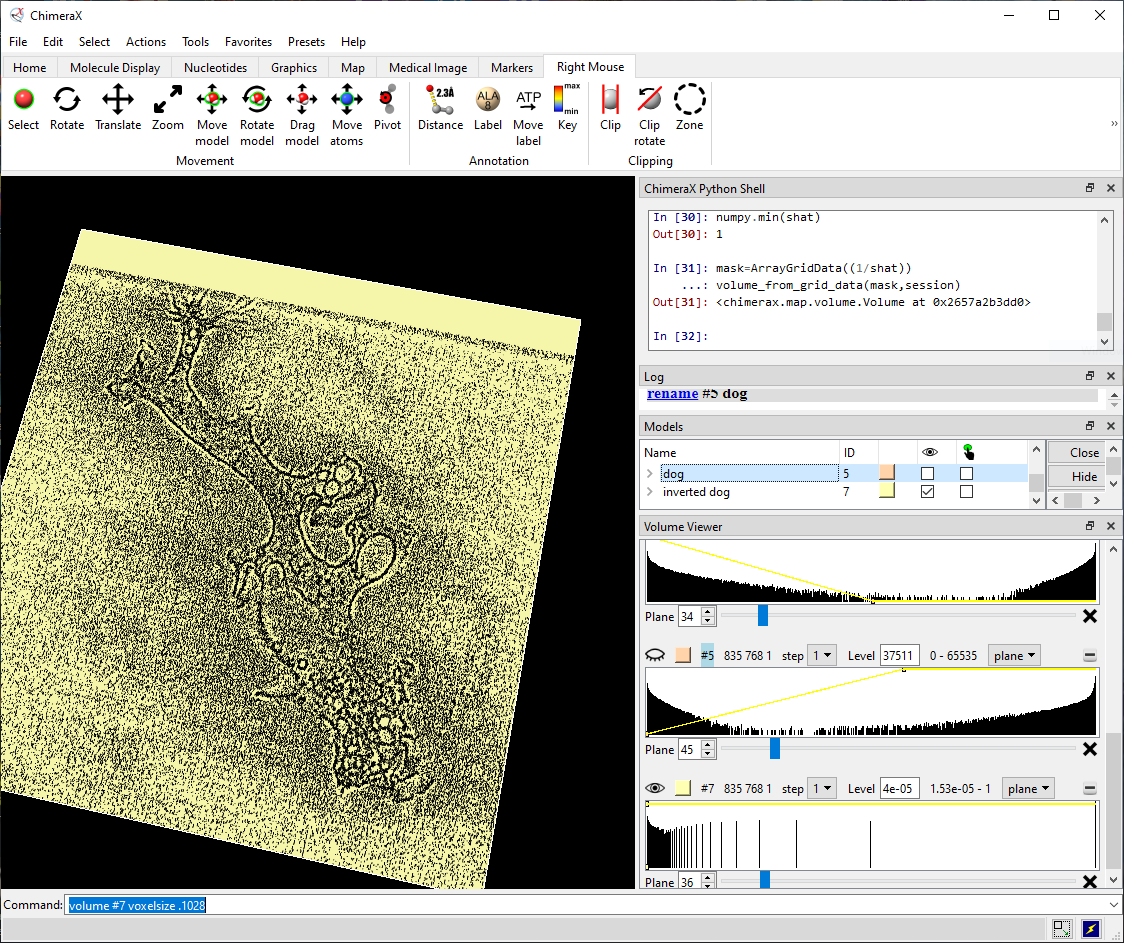

This shows great promis in the edge detection of the FLM membrane. I assume this will be an essential step in blod dectection.

In [ ]:
surface=session.models[1]
mask_vol = surface.volume.full_matrix().copy()
level = surface.volume.maximum_surface_level

gauss_1=gaussian_filter(mask_vol,sigma=0.25)
gauss_2=gaussian_filter(mask_vol,sigma=1)
hat=mask_vol*(gauss_2-gauss_1)

mask=ArrayGridData(((hat<=(numpy.max(hat)*.4))))

volume_from_grid_data(mask,session)

mask=ArrayGridData((hat_thresh*shadow_thresh))

volume_from_grid_data(mask,session)


Masking empty space witha DoG method shows enchanced negative space identification.

![Dog optimization.PNG](<attachment:Dog optimization.PNG>)
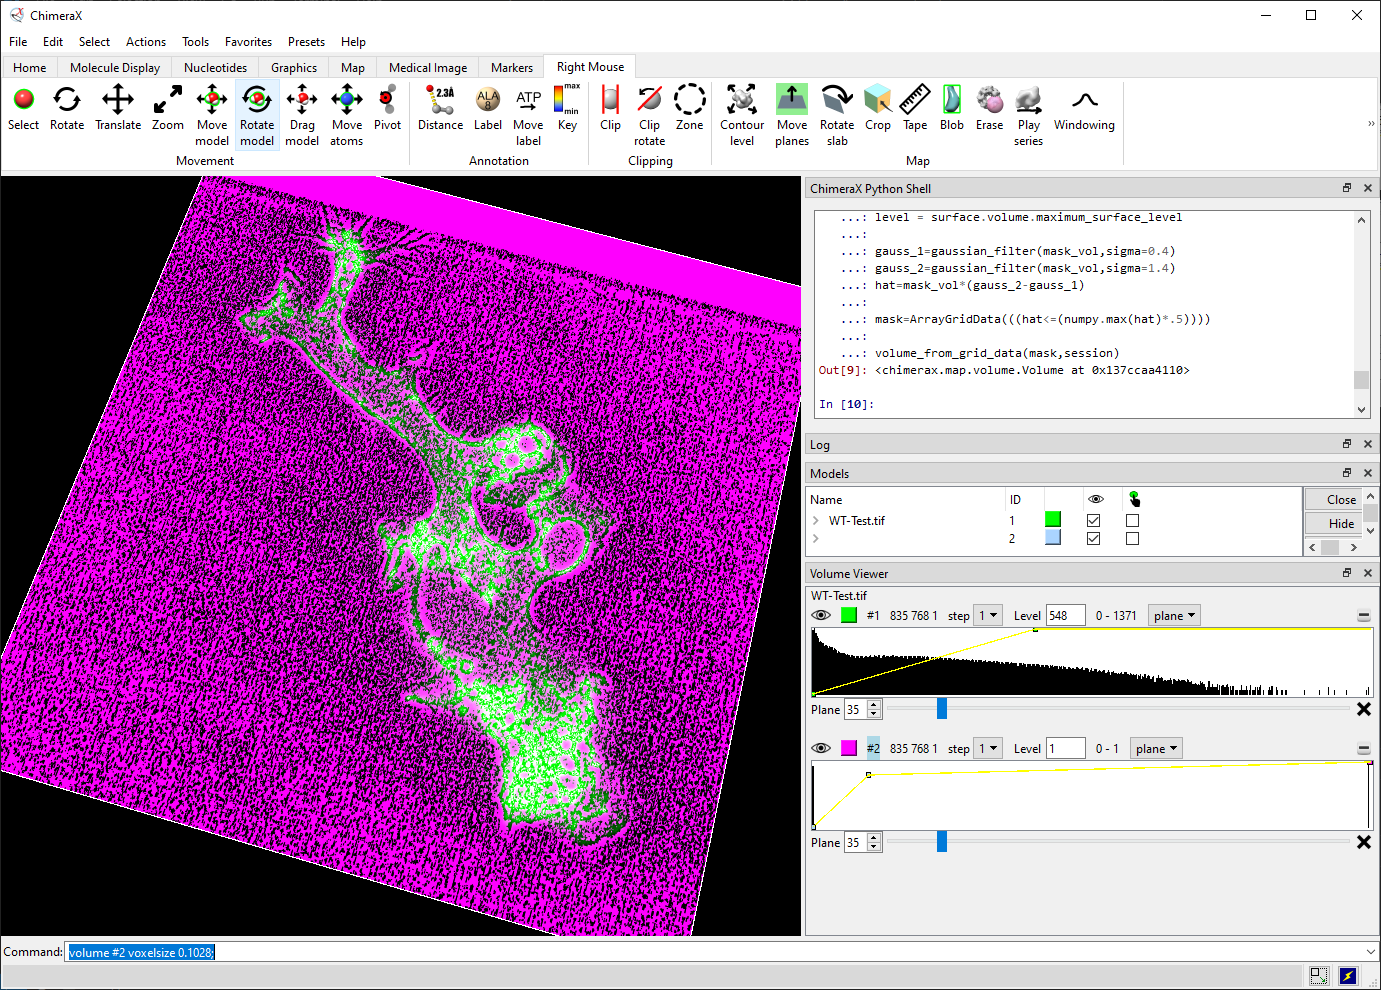

In [ ]:
shadow=gaussian_filter(mask_vol,sigma=3)

shadow_thresh=shadow>=(.1*numpy.max(shadow))

mask=ArrayGridData((shadow_thresh))

volume_from_grid_data(mask,session)


hat_thresh= (hat<=numpy.max(hat)*.5)


Using a gaussian blur I defin the ROI cell

![guassian-blur-mask.PNG](attachment:guassian-blur-mask.PNG)

apllication of the mask

![application of the masked roi.PNG](<attachment:application of the masked roi.PNG>)
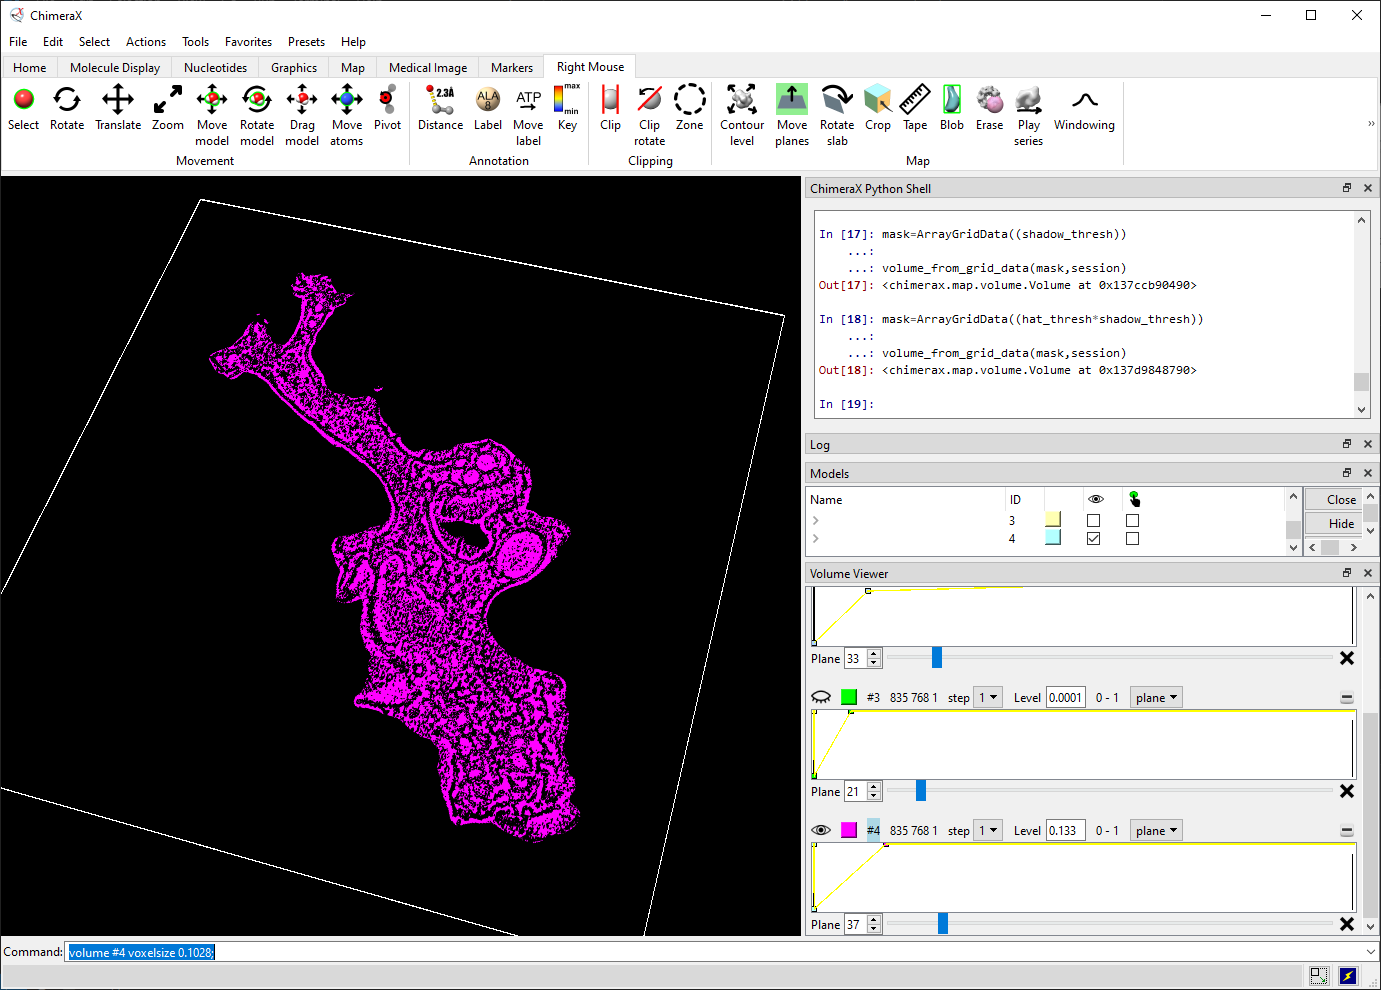

Logically I can follow this method to reatian all objects in the DoG and masking from the gaussian filter. With a simple logical argument we can exclude objects not within the size ranges of 0.5-5 um but will not be able to display those surfaces.

In [ ]:
surface=session.models[1]
mask_vol = surface.full_matrix().copy()
level = surface.maximum_surface_level

y=gaussian_laplace(mask_vol,sigma=.3)
mask=ArrayGridData((y*shadow_thresh))
volume_from_grid_data(mask,session)

.volume was removed now call matrix from moldes.full_matrix 2023-11-15

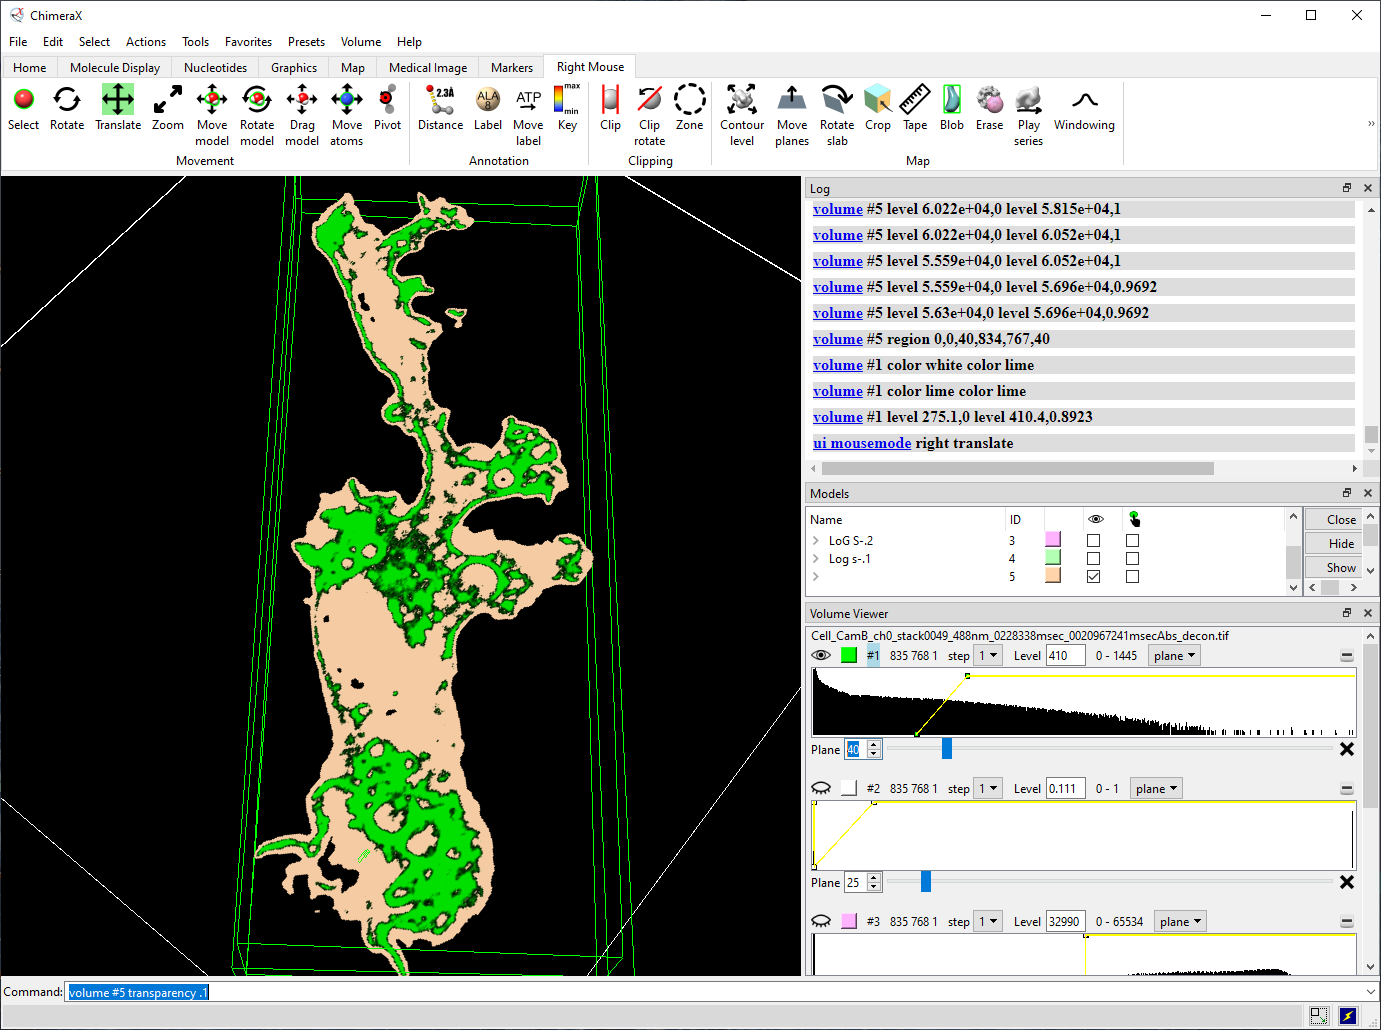
Laplacian of gaussian - sigma pt3 masking showen in pink displayed as a binary mask of the ~10% brightest point in and processed data in green 

In [ ]:
surface=session.models[1]
mask_vol = surface.full_matrix().copy()
level = surface.maximum_surface_level

y=gaussian_laplace(mask_vol,sigma=.2)

shadow=y
shadow_thresh=shadow>=(.85*numpy.max(shadow))

mask=ArrayGridData((y*shadow_thresh))
volume_from_grid_data(mask,session)

In [ ]:
surface=session.models[1]
mask_vol = surface.full_matrix().copy()
level = surface.maximum_surface_level

log1=gaussian_laplace(mask_vol,sigma=.2)
log2= gaussian_laplace(mask_vol,sigma=.3)
y=log2-log1
shadow=y
shadow_thresh=shadow>=(.85*numpy.max(shadow))

mask=ArrayGridData((y*shadow_thresh))
volume_from_grid_data(mask,session)

This idea of taking the difference of two laplicians of gaussians as you do in a Difference of gaussians failed to give improved results. output matrix was no bitter than the LoG.

using gradiant of gaussisian approach

In [ ]:
from scipy.ndimage import gaussian_gradient_magnitude

These fail

In [ ]:
surface=session.models[1]
mask_vol = surface.full_matrix().copy()
level = surface.maximum_surface_level

y=gaussian_laplace((mask_vol),sigma=.3,truncate=8.0)

shadow=y
shadow_thresh=shadow>=(.85*numpy.max(shadow))

mask=ArrayGridData((shadow_thresh))
volume_from_grid_data(mask,session)


Optimal LoG parameters found

From my literature search it seems that a process to improve the signal to noise ratio of the data is needed before edge detection.

New attempt to exclude values that fall in the 10-20th percentile of intensity values in the matrix inhopes of image enchancment

In [ ]:
surface=session.models[1]
mask_vol = surface.full_matrix().copy()
mean = numpy.nanmean(mask_vol,where=(mask_vol>110))
dev = numpy.nanstd(mask_vol,where=(mask_vol>110))

masked_image= (mask_vol >= (mean-(dev*.1)))
masking= (masked_image<1)

y_l=gaussian_laplace((mask_vol*masking),sigma=.3,truncate=3)
y=gaussian_laplace((mask_vol),sigma=.3,truncate=8)

shadow_l=y
shadow_thresh_l=shadow>=(.5*numpy.max(shadow_l))

shadow=y
shadow_thresh=shadow>=(.8*numpy.max(shadow))

mask=ArrayGridData((y*(shadow_thresh+shadow_thresh_l)))
volume_from_grid_data(mask,session)

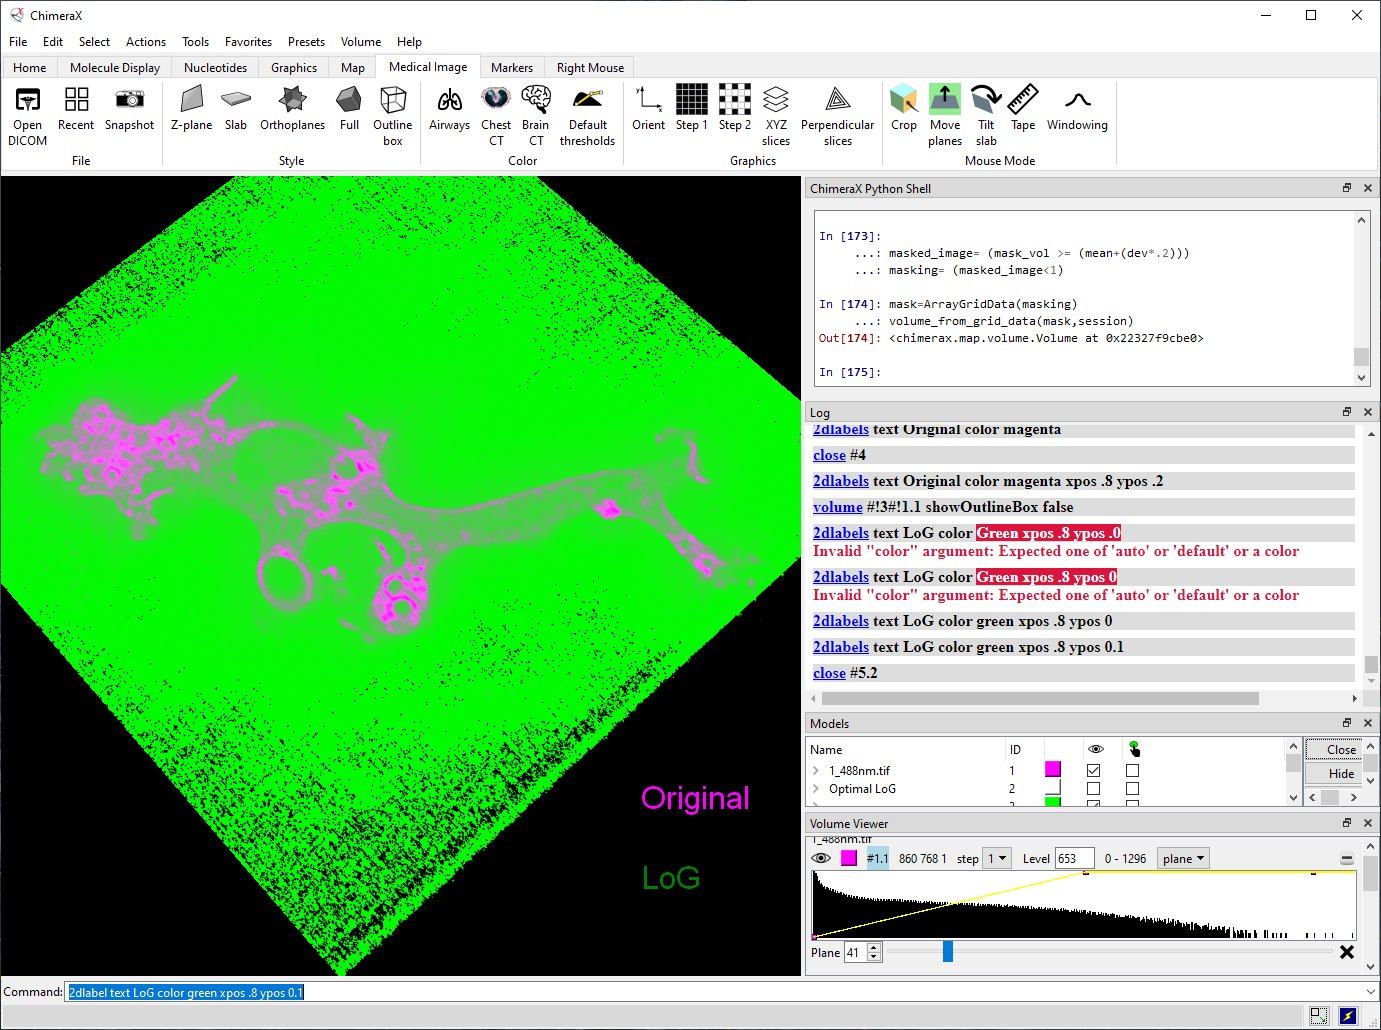

Process was done by application of two mask on the image data that was first ran through SciPy's Laplacian of Gaussian (LoG) function.

Mask 1: was made from excluding the lower 90 percential of the standard deviation from the mean of intensity values above 110. then finding the bighter half of a LoG of the image data 
Mask 2: was done by taking 80% of the bightest values in the LoG processed data.